In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

## 1

In [64]:
data = pd.read_csv("Stocks.csv", index_col=0)

# Cleaning the data
data.columns = data.columns.str.strip().str.replace('\ufeff', '')
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
stock_data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)
dher_prices = stock_data['DHER']
stock_data

,TUI,DHER,TMV
0,16.4907,98.86,12.625
1,17.7507,92.50,11.950
2,17.9249,89.76,11.845
3,17.8552,84.86,11.600
4,17.9481,85.10,11.395
...,...,...,...
890,7.4180,22.97,9.555
891,7.7060,23.96,9.485
892,7.6460,23.77,9.435
893,7.6200,23.67,9.670


In [65]:
# ln(P_t / P_{t-1})
log_returns = np.log(dher_prices / dher_prices.shift(1))
daily_volatility = log_returns.std()
daily_volatility_percent = daily_volatility * 100
print(f"daily log- returns vola DHER is: {daily_volatility_percent:.2f}%")


daily log- returns vola DHER is: 4.37%


In [66]:
print(daily_volatility)

# scaling factors
numTradingDays = 252
numCalenderDays = 360 


vol_cal_day = daily_volatility * 100
vola_trading_year = daily_volatility * np.sqrt(numTradingDays) * 100
vola_calendar_year = daily_volatility * np.sqrt(numCalenderDays) * 100

0.04370516281602138


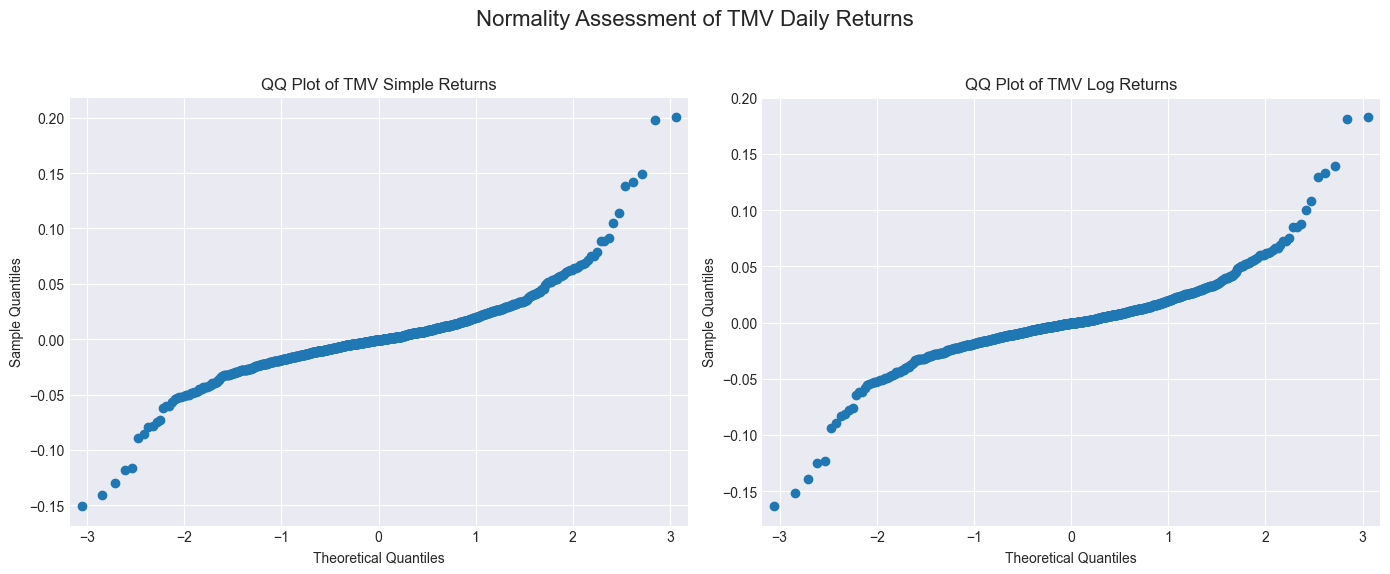

In [67]:
tmv_prices = data['TMV']

# (P_t - P_{t-1}) / P_{t-1}
simple_ret_tmv = tmv_prices.pct_change().dropna()

# ln(P_t / P_{t-1})
log_returns_tmv = np.log(tmv_prices / tmv_prices.shift(1)).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sm.qqplot(simple_ret_tmv, ax=axes[0])
axes[0].set_title('QQ Plot of TMV Simple Returns')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')

sm.qqplot(log_returns_tmv, ax=axes[1])
axes[1].set_title('QQ Plot of TMV Log Returns')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

fig.suptitle('Normality Assessment of TMV Daily Returns', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

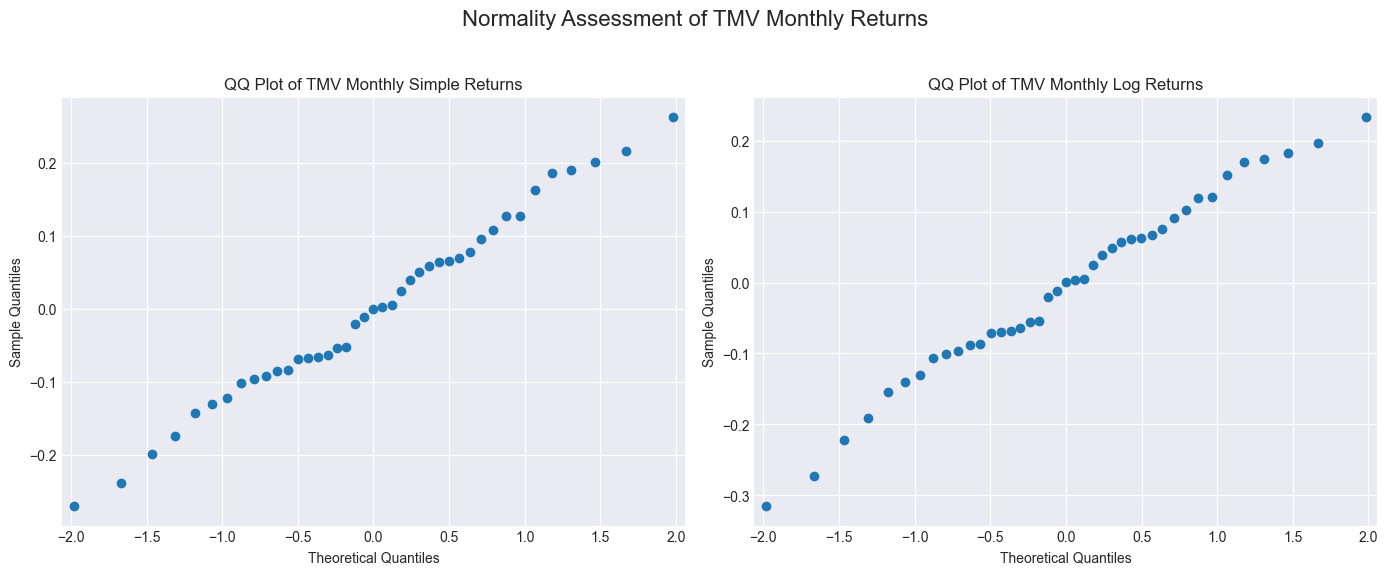

In [68]:
tmv_prices_monthly = data['TMV'].resample('ME').last()
tmv_prices_monthly = tmv_prices_monthly.loc['2022-01-01':'2025-06-30']

simple_returns_monthly = tmv_prices_monthly.pct_change().dropna()
log_returns_monthly = np.log(tmv_prices_monthly / tmv_prices_monthly.shift(1)).dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sm.qqplot(simple_returns_monthly, ax=axes[0])
axes[0].set_title('QQ Plot of TMV Monthly Simple Returns')
axes[0].set_xlabel('Theoretical Quantiles')
axes[0].set_ylabel('Sample Quantiles')

sm.qqplot(log_returns_monthly, ax=axes[1])
axes[1].set_title('QQ Plot of TMV Monthly Log Returns')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

fig.suptitle('Normality Assessment of TMV Monthly Returns', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [69]:
log_returns = np.log(data / data.shift(1))
log_returns = log_returns.dropna()
correlation_matrix = log_returns.corr()

print("--- Correlation Matrix (Decimal) ---")
print(correlation_matrix)
print("\n" + "="*40 + "\n")


corr_tui_dher = correlation_matrix.loc['TUI', 'DHER']
corr_tui_tmv = correlation_matrix.loc['TUI', 'TMV']
corr_dher_tmv = correlation_matrix.loc['DHER', 'TMV']


print("--- Pairwise Correlations (Percentage) ---")
print(f"Correlation between TUI and DHER: {corr_tui_dher * 100:.1f}%")
print(f"Correlation between TUI and TMV: {corr_tui_tmv * 100:.1f}%")
print(f"Correlation between DHER and TMV: {corr_dher_tmv * 100:.1f}%")


--- Correlation Matrix (Decimal) ---
           TUI      DHER       TMV
TUI   1.000000  0.328562  0.273411
DHER  0.328562  1.000000  0.324302
TMV   0.273411  0.324302  1.000000


--- Pairwise Correlations (Percentage) ---
Correlation between TUI and DHER: 32.9%
Correlation between TUI and TMV: 27.3%
Correlation between DHER and TMV: 32.4%


In [70]:
# Calculate the variance-covariance matrix on the log returns
cov_matrix = log_returns.cov()
print(cov_matrix)

inv_cov_matrix = np.linalg.inv(cov_matrix)
ones_vector = np.ones(len(data.columns))
numerator = inv_cov_matrix.dot(ones_vector)

denominator = ones_vector.T.dot(inv_cov_matrix).dot(ones_vector)

mvp_weights_decimal = numerator / denominator

mvp_weights = pd.Series(mvp_weights_decimal, index=data.columns)

print("--- Minimum-Variance Portfolio Weights ---")
# Convert to percentage and format
mvp_weights_percent = mvp_weights * 100

print(f"TUI:  {mvp_weights_percent['TUI']:.1f}%")
print(f"DHER: {mvp_weights_percent['DHER']:.1f}%")
print(f"TMV:  {mvp_weights_percent['TMV']:.1f}%")

           TUI      DHER       TMV
TUI   0.000913  0.000434  0.000231
DHER  0.000434  0.001910  0.000396
TMV   0.000231  0.000396  0.000779
--- Minimum-Variance Portfolio Weights ---
TUI:  40.9%
DHER: 7.5%
TMV:  51.5%


In [71]:
mean_returns = log_returns.mean()
    
# expected daily return of the portfolio 
portfolio_return = mvp_weights_decimal.T.dot(mean_returns)
portfolio_variance = mvp_weights_decimal.T.dot(cov_matrix).dot(mvp_weights_decimal)

portfolio_std_dev = np.sqrt(portfolio_variance)

print("--- MVP Return and Standard Deviation ---")

portfolio_return_percent = abs(portfolio_return * 100)
portfolio_std_dev_percent = portfolio_std_dev * 100

print(f"Return:            {portfolio_return_percent:.2f}%")
print(f"Standard deviation:  {portfolio_std_dev_percent:.2f}%")
    

--- MVP Return and Standard Deviation ---
Return:            0.06%
Standard deviation:  2.29%


In [ ]:
trading_days = 252
mean_returns_annual = log_returns.mean() * trading_days
cov_matrix_annual = log_returns.cov() * trading_days

num_portfolios = 20000
portfolio_returns = []
portfolio_volatilities = []

for i in range(num_portfolios):
    weights = np.random.random(len(data.columns))
    weights /= np.sum(weights)
    port_return = np.sum(mean_returns_annual * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))
    portfolio_returns.append(port_return)
    portfolio_volatilities.append(port_volatility)

cov_matrix_daily = log_returns.cov()
inv_cov_matrix = np.linalg.inv(cov_matrix_daily)
ones_vector = np.ones(len(data.columns))

numerator = inv_cov_matrix.dot(ones_vector)
denominator = ones_vector.T.dot(inv_cov_matrix).dot(ones_vector)
mvp_weights = numerator / denominator


mvp_return = np.sum(mean_returns_annual * mvp_weights)
mvp_volatility = np.sqrt(np.dot(mvp_weights.T, np.dot(cov_matrix_annual, mvp_weights)))


plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities, portfolio_returns, c='skyblue', marker='o', s=10, alpha=0.4, label='Simulated Portfolios')
plt.scatter(mvp_volatility, mvp_return, c='red', marker='*', s=250, edgecolors='black', label='Minimum-Variance Portfolio (MVP)')
plt.title('Mean-Variance Frontier for TUI, DHER, and TMV', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))

plt.legend()
plt.show()

SyntaxError: invalid syntax (2298051110.py, line 35)

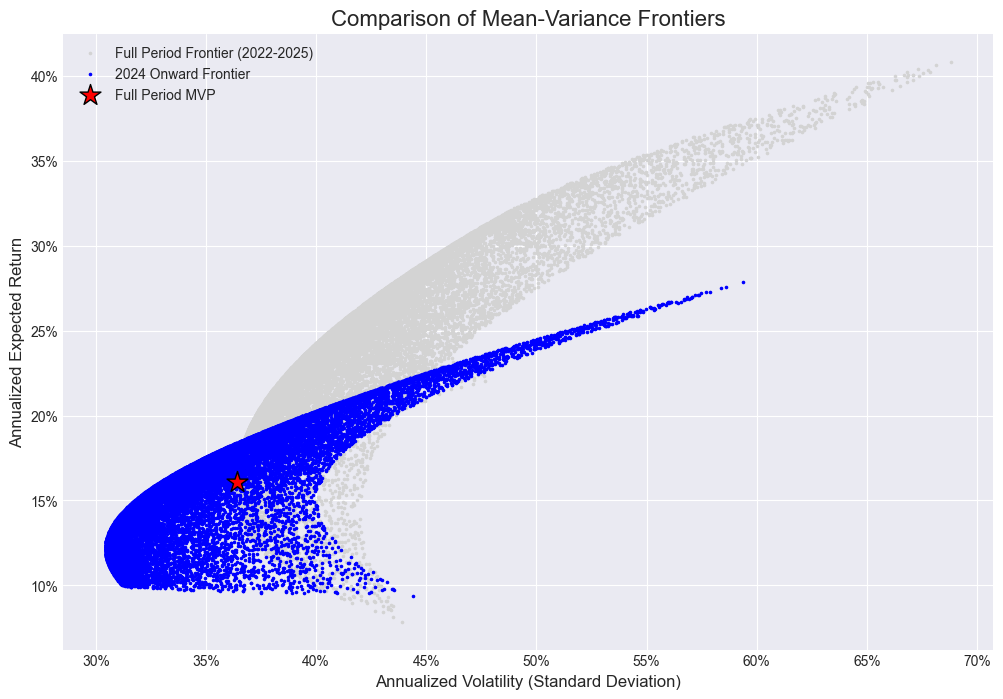

In [ ]:
start_date = "2023-01-05"
stock_data_2024 = data[data.index >= pd.to_datetime(start_date)]
log_returns_2024 = np.log(stock_data_2024[data.columns] / stock_data_2024[data.columns].shift(1)).dropna()

mean_returns_annual_2024 = log_returns_2024.mean() * trading_days
cov_matrix_annual_2024 = log_returns_2024.cov() * trading_days

portfolio_returns_2024 = []
portfolio_volatilities_2024 = []

for i in range(num_portfolios):
    weights = np.random.random(len(data.columns))
    weights /= np.sum(weights)
    port_return = np.sum(mean_returns_annual_2024 * weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual_2024, weights)))
    portfolio_returns_2024.append(port_return)
    portfolio_volatilities_2024.append(port_volatility)

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatilities, portfolio_returns, c='lightgray', marker='.', s=10, label='Full Period Frontier (2022-2025)')


plt.scatter(portfolio_volatilities_2024, portfolio_returns_2024, c='blue', marker='.', s=10, label='2024 Onward Frontier')
plt.scatter(mvp_volatility, mvp_return, c='red', marker='*', s=250, edgecolors='black', label='Full Period MVP')

# Formatting
plt.title('Comparison of Mean-Variance Frontiers', fontsize=16)
plt.xlabel('Annualized Volatility (Standard Deviation)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.legend()
plt.show()